In [2]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import anndata as ad

# hPSC organoids
org = pd.read_csv('data/hPSC_fetal_lung_org_counts.csv', index_col=0).T
org = ad.AnnData(org)
scv.pp.remove_duplicate_cells(org)
org.obs['cell_type'] = 'hPSC organoids'
org.obs['cell_type_num'] = 'hPSC organoids (21)'
org.obs['batch'] = 'hPSC organoids'

# hPSC fetal lung cells
S3 = pd.read_csv('data/hPSC_fetal_lung_cells_counts.csv', index_col=0).T
S3 = ad.AnnData(S3)
scv.pp.remove_duplicate_cells(S3)
S3.obs['cell_type'] = 'hPSC fetal lung cells'
S3.obs['cell_type_num'] = 'hPSC fetal lung cells (20)'
S3.obs['batch'] = 'hPSC fetal lung cells'

# fetal lung cells
adata = sc.read('../../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c2_anndata.h5ad')

meta = pd.read_csv('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c2_metadata_Aug19.csv',
                  index_col=0)
umap = pd.read_csv('../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/lung/raw_c2/c2_Embeddings.csv',
                  index_col=0)

adata.obs['id'] = [str(x.split('-')[0]) +'-'+ str(x.split('-')[1]) for x in adata.obs.index.values]
adata.obs = adata.obs.set_index('id')

adata.obs['cell_type'] = meta['cell_type']
adata.obs['cell_type_num'] = meta['cell_type_Aug']
adata.obs['sample_week'] = meta['sample_week']
adata.obs['UMAP1'] = umap['UMAP_1']
adata.obs['UMAP2'] = umap['UMAP_2']
adata.obsm['X_umap'] = np.array([adata.obs.UMAP1, adata.obs.UMAP2]).T
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_num'] = adata.obs['cell_type_num'].astype('category')
adata.obs['cell_type'] = adata.obs['cell_type'].cat.rename_categories({'SOX2+CFTR+ 2 cells': 'SOX2highCFTR+ cells',
                                                                      'SOX2+CFTR+ 1 cells': 'SOX2lowCFTR+ cells',
                                                                      'Early AT2-like cells': 'Tip cells'})
adata.obs['cell_type_num'] = adata.obs['cell_type_num'].cat.rename_categories({'Early AT2-like cells (4)': 'Tip cells (4)'})
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_num'] = adata.obs['cell_type_num'].astype('category')
adata = adata[~adata.obs['cell_type'].isna()]

org = org[:,~org.var.index.duplicated(keep='first')]
S3 = S3[:,~S3.var.index.duplicated(keep='first')]


In [3]:
integrated = ad.concat([adata, S3, org], label='batch_')

In [4]:
sc.pp.filter_genes(integrated, min_cells=30)
sc.pp.normalize_total(integrated)
sc.pp.log1p(integrated)

In [5]:
sc.pp.highly_variable_genes(integrated, n_top_genes = 3000, flavor='cell_ranger', batch_key='batch', subset=False)

In [6]:
scv.pp.pca(integrated, use_highly_variable=False)
sc.external.pp.bbknn(integrated, batch_key='batch')

In [7]:
scv.tl.umap(integrated, min_dist=0.25)

In [8]:
scv.tl.louvain(integrated, resolution=2.25)

In [9]:
epi_palette =  {'Basal cells':'#1f77b4', 'Budtip progenitors':'#ff7f0e', 'Ciliated precursor cells':'#2ca02c', 'Club cells':'#d62728', 'Tip cells':'#9467bd', 'Mature ciliated cells':'#8c564b', 'NKX2-1+SOX9+CFTR+ cells':'#e377c2', 'NRGN+ cells':'#7f7f7f', 'PNEC':'#bcbd22', 'PTEN+STAT3+ cells':'#17becf', 'Proliferating progenitors':'#aec7e8', 'SCGB3A2+FOXJ1+ cells':'#ffbb78', 'SCGB3A2+SFTPB+CFTR+ cells':'#98df8a', 'SMG basal cells':'#ff9896', 'SMG secretory cells':'#c5b0d5', 'SOX2lowCFTR+ cells': '#f7b6d2', 'SOX2highCFTR+ cells': '#c49c94', 'Stromal-like cells 1':'#c7c7c7', 'Stromal-like cells 2':'#dbdb8d',
               'hPSC fetal lung cells':'#a55194', 'hPSC organoids': '#8ca252'} 

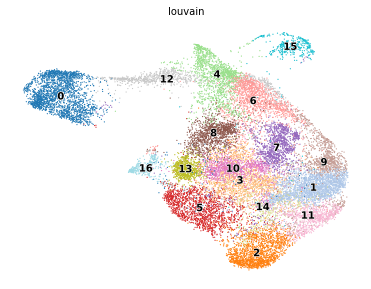

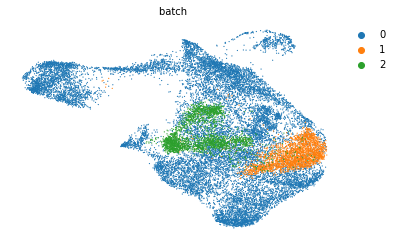

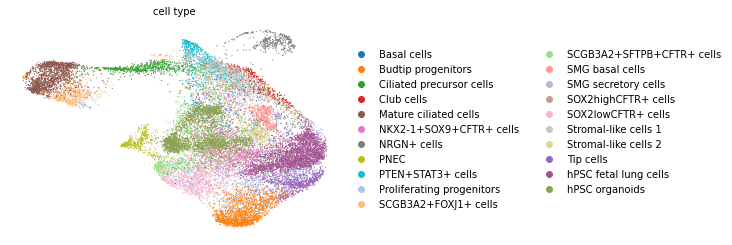

In [10]:
scv.pl.umap(integrated, color='louvain', palette='tab20')
scv.pl.umap(integrated, color='batch_')
scv.pl.umap(integrated, color='cell_type', legend_loc='right',
           palette=epi_palette)

In [12]:
integrated.write('data/integrated.h5ad')